# Classification de Postures par Fusion d’Images et de Points Clés avec VGG16 & MoveNet

Ce notebook présente un pipeline complet pour la classification d’images selon la posture, en combinant les caractéristiques extraites par un modèle VGG16 et les points clés du corps détectés par MoveNet.

**Exemple d'application : ce notebook est utilisé pour la classification automatique des postures lors des gestes de dépistage du cancer du sein.**

## Objectifs

- Classifier des images selon différentes postures ou positions corporelles.
- Utiliser à la fois les informations visuelles (features extraites par VGG16) et les points clés du squelette humain (keypoints MoveNet) pour améliorer la robustesse de la classification.
- Évaluer les performances du modèle sur des jeux de données réels.

## Pipeline du notebook

1. **Montage de Google Drive**
   - Accès aux datasets et sauvegarde des modèles.

2. **Installation et import des dépendances**
   - TensorFlow, TensorFlow Hub, OpenCV, scikit-learn, matplotlib, seaborn, etc.

3. **Préparation des données**
   - Chargement des images organisées par classe.
   - Détection automatique des points clés (keypoints) sur chaque image avec MoveNet.
   - Prétraitement des images et création des labels.

4. **Construction du modèle**
   - Extraction des features visuelles avec VGG16 (pré-entraîné ImageNet).
   - Fusion des features VGG16 et des keypoints dans un réseau de neurones dense.
   - Entraînement du modèle sur les images et les keypoints.

5. **Évaluation**
   - Séparation des données en train/validation/test.
   - Calcul des métriques (accuracy, précision, rappel, matrice de confusion).
   - Visualisation des courbes de perte et de la matrice de confusion.

6. **Prédiction et test**
   - Prédiction de la classe d’une nouvelle image.
   - Test du modèle sur un dossier d’images.

7. **Gestion mémoire**
   - Libération de la mémoire GPU/CPU après l’entraînement.

## Applications

- Détection automatique de postures pour le sport, la santé, la rééducation, la sécurité, etc.
- Analyse de mouvements humains à partir d’images ou de vidéos.

---

> Ce notebook démontre comment combiner efficacement vision par ordinateur et analyse de pose pour améliorer la classification d’images de postures.  
> **Différence principale avec le notebook ResNet : ici, le backbone utilisé pour l’extraction de features visuelles est VGG16 au lieu de ResNet50.**

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import os
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Concatenate, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available and set to memory growth mode")
else:
    print("No GPU found, using CPU")

model_movenet = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
movenet = model_movenet.signatures['serving_default']


def detect_keypoints(image):
    input_image = tf.image.resize(image, (256, 256))
    input_image = tf.expand_dims(input_image, axis=0)
    input_image = tf.cast(input_image, dtype=tf.int32)

    outputs = movenet(input_image)
    keypoints = outputs['output_0'].numpy()

    return keypoints[0][0]


def load_and_process_images(base_path):
    images = []
    keypoints_list = []
    labels = []
    class_names = sorted(os.listdir(base_path))

    for class_name in class_names:
        class_path = os.path.join(base_path, class_name)
        label = class_names.index(class_name)

        for filename in os.listdir(class_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_path = os.path.join(class_path, filename)
                image = cv2.imread(image_path)
                #Convertit les images en RGB
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                #détecte les points clés
                keypoints = detect_keypoints(image_rgb)
                keypoints_list.append(keypoints)

                #redimensionne les images et les prétraite
                image_rgb = cv2.resize(image_rgb, (224, 224))
                image_rgb = preprocess_input(image_rgb)
                images.append(image_rgb)
                labels.append(label)

    return np.array(images), np.array(keypoints_list), np.array(labels), class_names

train_base_path = '/content/drive/MyDrive/Master 2/dataset_aug/train'
test_base_path = '/content/drive/MyDrive/Master 2/dataset_aug/test'

X_train_images, X_train_keypoints, y_train, class_names = load_and_process_images(train_base_path)
X_test_images, X_test_keypoints, y_test, _ = load_and_process_images(test_base_path)

X_train_images, X_val_images, X_train_keypoints, X_val_keypoints, y_train, y_val = train_test_split(
    X_train_images, X_train_keypoints, y_train, test_size=0.15, random_state=42
)

GPU is available and set to memory growth mode


Epoch 1/80
15/15 [==============================] - 70s 2s/step - loss: 4.7437 - accuracy: 0.2597 - val_loss: 1.3700 - val_accuracy: 0.4553
Epoch 2/80
15/15 [==============================] - 10s 645ms/step - loss: 1.3728 - accuracy: 0.2927 - val_loss: 1.3176 - val_accuracy: 0.5366
Epoch 3/80
15/15 [==============================] - 10s 640ms/step - loss: 1.3106 - accuracy: 0.3974 - val_loss: 1.2208 - val_accuracy: 0.7480
Epoch 4/80
15/15 [==============================] - 10s 637ms/step - loss: 1.1939 - accuracy: 0.5294 - val_loss: 1.0838 - val_accuracy: 0.8780
Epoch 5/80
15/15 [==============================] - 10s 640ms/step - loss: 1.0562 - accuracy: 0.6614 - val_loss: 0.8959 - val_accuracy: 0.9675
Epoch 6/80
15/15 [==============================] - 10s 642ms/step - loss: 0.8788 - accuracy: 0.7446 - val_loss: 0.7332 - val_accuracy: 0.9350
Epoch 7/80
15/15 [==============================] - 10s 645ms/step - loss: 0.7325 - accuracy: 0.7848 - val_loss: 0.5635 - val_accuracy: 0.9350
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 10s 414ms/step - loss: 0.2777 - accuracy: 0.9508
Accuracy: 0.9507575631141663
9/9 [==============================] - 1s 129ms/step
Confusion Matrix:
[[60  0  6  0]
 [ 1 63  2  0]
 [ 1  0 59  0]
 [ 1  2  0 69]]
Accuracy: 0.9507575757575758
Precision: 0.9532658883405153
Recall: 0.9507575757575758


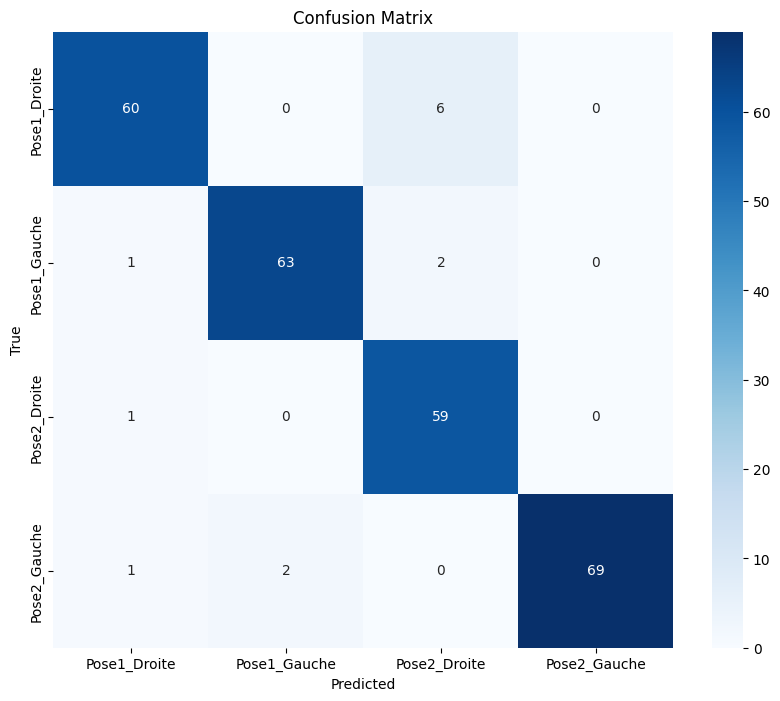

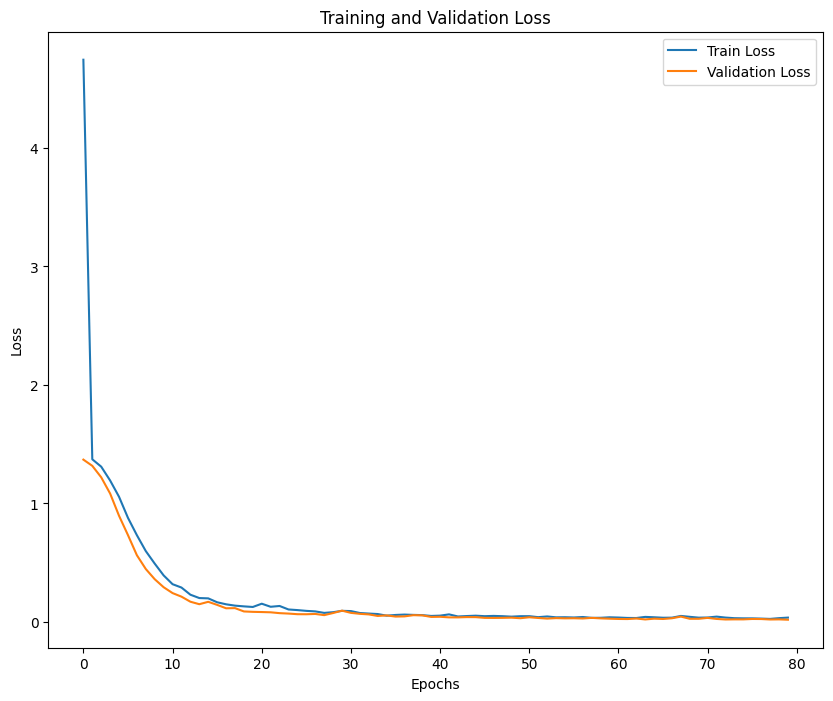

In [ ]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)


keypoints_input = Input(shape=(17, 3))
flattened_keypoints = Flatten()(keypoints_input)



combined = Concatenate()([x, flattened_keypoints])


combined = Dense(1024, activation='relu')(combined)
combined = Dropout(0.5)(combined)
combined = Dense(512, activation='relu')(combined)
combined = Dropout(0.5)(combined)
predictions = Dense(len(class_names), activation='softmax')(combined)

model = Model(inputs=[base_model.input, keypoints_input], outputs=predictions)

for layer in base_model.layers[-15:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history = model.fit(
    [X_train_images, X_train_keypoints], y_train,
    epochs=80, batch_size=48,
    validation_data=([X_val_images, X_val_keypoints], y_val)
)

model.save('/content/drive/MyDrive/Master 2/pose_classification_model_vgg16_with_keypoints_V1.h5')

loaded_model = load_model('/content/drive/MyDrive/Master 2/pose_classification_model_vgg16_with_keypoints_V1.h5')


loss, accuracy = loaded_model.evaluate([X_test_images, X_test_keypoints], y_test)
print(f'Accuracy: {accuracy}')

y_pred = loaded_model.predict([X_test_images, X_test_keypoints])
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
